# CIL Challenge 1: Collaborative Filtering

## Overview

The challenge consists of reading a series of data points representing
ratings users gave to some items, and predicting all other ratings in the
user-item rating matrix, using various techniques, most of which are based
on SVD (Singular Value Decomposition).

## TODO and Ideas
 * Try out iterative SVD (Nikos' idea).
 * Try out regularized SGD (see news article linked in exercise sheet on CF in practice and the Netflix prize).
 * Try to improve SGD using biases (user bias, item bias).
 * Try out k-means (should perform wors technically).
 * Try to combine k-means with SVD.

## Data Wrangling

In [1]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import copy
import random

In [2]:
def full_svd(matrix):
    """Utility which returns full SVD matrices.
    
    Works around the fact that numpy's SVD function returns the 'd'
    as a vector of singular values, instead of a diagonal matrix.
    """
    U, d, V = np.linalg.svd(matrix, full_matrices=True)
    D = np.zeros(matrix.shape)
    D[:d.shape[0],:d.shape[0]] = np.diag(d)
    return U, D, V

In [3]:
def load_ratings(data_file):
    """Loads the rating data from the specified file. 
    
    Does not yet build the rating matrix. Use 'ratings_to_matrix' to do that.
    Assumes the file has a header (which is ignored), and that the ratings are
    then specified as 'rXXX_cXXX,X', where the 'X' blanks specify the row, the
    column, and then the actual (integer) rating.
    """
    ratings = []
    with open(data_file, 'r') as file:
        header = file.readline()
        # print("Header: %s" % header)
        for line in file:
            key, value_string = line.split(",")
            rating = int(value_string)
            row_string, col_string = key.split("_")
            row = int(row_string[1:])
            col = int(col_string[1:])
            
            if rating < 1 or rating > 5:
                raise ValueError("Found illegal rating value [%d]." % rating)
            
            ratings.append((row - 1, col - 1, rating))
            
    return ratings

def ratings_to_matrix(ratings, matrix_rows, matrix_cols):
    """Converts a list of ratings to a numpy matrix."""
    print("Building [%d x %d] rating matrix." % (matrix_rows, matrix_cols))
    matrix = np.zeros([matrix_rows, matrix_cols])
    for (row, col, rating) in ratings:
        matrix[row, col] = rating
        
    print("Finished building rating matrix.")
    return matrix

In [4]:
# Rows are users
USER_COUNT = 10000

# Columns are items
ITEM_COUNT = 1000

VALIDATION_RATIO = 0.1
TRAINING_RATIO = 1 - VALIDATION_RATIO

In [5]:
RANDOM_SEED = 0xC0FFEE
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

In [6]:
all_ratings = load_ratings('data/cf/data_train.csv')

In [7]:
data_matrix = ratings_to_matrix(all_ratings, USER_COUNT, ITEM_COUNT)

Building [10000 x 1000] rating matrix.
Finished building rating matrix.


In [8]:
all_ratings_count = len(all_ratings)
print("We have [%d] data points." % all_ratings_count)

validation_count = int(VALIDATION_RATIO * all_ratings_count)
training_count = all_ratings_count - validation_count
print("Will use [%d] data points for validation, and [%d] for training." %
     (validation_count, training_count))

We have [1388107] data points.
Will use [138810] data points for validation, and [1249297] for training.


In [9]:
def shuffle_split_data(all_data, training_count, validation_count):
    """Returns a split consisting of (training, validation) data, created
    after shuffling the input data.
    """
    to_shuffle = copy.copy(all_data)
    random.shuffle(to_shuffle)
    return to_shuffle[:training_count], to_shuffle[training_count:]

In [10]:
train, validation = shuffle_split_data(all_ratings, training_count, validation_count)
train_matrix = ratings_to_matrix(train, USER_COUNT, ITEM_COUNT)
validation_matrix = ratings_to_matrix(validation, USER_COUNT, ITEM_COUNT)

assert len(train_matrix[train_matrix != 0]) == training_count
assert len(validation_matrix[validation_matrix != 0]) == validation_count

Building [10000 x 1000] rating matrix.
Finished building rating matrix.
Building [10000 x 1000] rating matrix.
Finished building rating matrix.


In [11]:
def score_predictions(prediction_matrix, validation_matrix):
    """Computes the RMSE score for the prediction matrix based
    on the data points present in the validation matrix.
    
    """
    
    # Want to compute RMSE just for nonzero validation elements.
    mask = (validation_matrix != 0)
    count = np.sum(mask)
    actual = prediction_matrix[mask]
    real = validation_matrix[mask]
    
    delta = np.abs(actual - real)
    delta = delta * delta
    delta = np.sum(delta)
    
    score = np.sqrt(delta / count)
    return score


def score_predictions_slow(prediction_matrix, validation_matrix):
    s = 0
    count = 0 #np.sum(validation_matrix > 0)
    for row in range(validation_matrix.shape[0]):
        for col in range(validation_matrix.shape[1]):
            if validation_matrix[row, col] > 0:
                delta = (validation_matrix[row, col] - prediction_matrix[row, col]) ** 2
                s += delta
                count += 1
                
    score = np.sqrt(s * 1.0 / count)
    return score

In [12]:
def predict_by_avg_avg(data):
    """Imputation by averaging mean user and mean item rating in every cell.
    
    """
    
    # These are the indices of the cells where we have no data.
    to_impute = (data == 0)
    if np.sum(to_impute) == 0:
        raise ValueError("Sanity check: found no values for imputation!")
        
    item_pred = predict_by_avg(data, averaging=0)
    user_pred = predict_by_avg(data, averaging=1)
    
    avg_pred = (item_pred + user_pred) / 2
    prediction = np.copy(data)
    
    print(avg_pred.shape)
    print(prediction.shape)
    print(to_impute.shape)
    
    # Only update the data that were missing to begin with.
    for (i, row) in enumerate(prediction):
        row[row == 0] = avg_pred[i, row == 0]
    return prediction
    
    
def predict_by_rating_avg(data):
    """Imputation by average rating in the whole system."""
    # TODO(andrei) Median? Percentiles?
    mean_rating = np.mean(data[data != 0])
    prediction = np.copy(data)
    prediction[data == 0] = mean_rating
    return prediction
    

def predict_by_avg(data, averaging=0):
    """Performs naive data imputation.
    
    Arguments:
        data: The numpy data matrix on which to operate.
        averaging: Enum specifying how to average:
            0: perform column averaging (avg. item rating)
            1: perform row averaging (avg. user rating)
            
    Returns:
        An updated copy of the original matrix.
    """
    
    nonzero = (data != 0)
    
    # Sum on the 0th axis => per-item ratings.
    # Sum on the 1st axis => per-user ratings.
    if averaging == 0:
        axis = 0
    elif averaging == 1:
        axis = 1
    else:
        raise ValueError("Unknown averaging type [%s]." % str(averaging))
        
    rating_counts = nonzero.sum(axis)
    rating_sums = data.sum(axis)
    avg_ratings = rating_sums / rating_counts
    predictions = np.copy(data)
    
    print("Got %d average ratings." % len(avg_ratings))
    
    if averaging == 0:
        for col in range(data.shape[1]):
            no_rating = (predictions[:, col] == 0)
            predictions[no_rating, col] = avg_ratings[col]
    else:
        for row in range(data.shape[0]):
            no_rating = (predictions[row, :] == 0)
            predictions[row, no_rating] = avg_ratings[row]

    zero_pred = (predictions == 0)
    assert np.sum(zero_pred) == 0
    return predictions
    

def predict_by_avg_item_rating(data):
    return predict_by_avg(data, averaging=0)


def predict_by_avg_user_rating(data):
    return predict_by_avg(data, averaging=1)


item_impute = predict_by_avg_item_rating(train_matrix)
user_impute = predict_by_avg_user_rating(train_matrix)
mean_user_item_impute = predict_by_avg_avg(train_matrix)
mean_impute = predict_by_rating_avg(train_matrix)

print("Mean rating RMSE: %.4f" % score_predictions(mean_impute, validation_matrix))
print("User rating RMSE: %.4f" % score_predictions(user_impute, validation_matrix))
print("Item rating RMSE: %.4f" % score_predictions(item_impute, validation_matrix))
print("Mean user and item rating RMSE: %.4f" % score_predictions(mean_user_item_impute, validation_matrix))

# print("RMSE: %.4f" % score_predictions_slow(no_svd_result, validation_matrix))

Got 1000 average ratings.
Got 10000 average ratings.
Got 1000 average ratings.
Got 10000 average ratings.
(10000, 1000)
(10000, 1000)
(10000, 1000)
Mean rating RMSE: 1.1211
User rating RMSE: 1.0853
Item rating RMSE: 1.0312
Mean user and item rating RMSE: 1.0254


In [13]:
def svd_predict(data, k=290, sanity_check=False):
    """Predict the missing values in the data matrix using SVD.
    
    Imputes the missing values using column-wise means, and then improves the
    prediction using singular value decomposition.
    
    Arguments:
        data: The data matrix with missing values on which to apply SVD.
        k: The number of singular values to keep.
        sanity_check: Whether to perform additional (potentially slow) sanity checks.
    """
    # Note: this function does not apply the 'sqrt(D)' pre-multiplication
    # trick specified in the exercise sheet, as it led to a strange (and
    # likely silly) bug.
    
    imputed = predict_by_avg_item_rating(data)
    U, d, V = np.linalg.svd(imputed, full_matrices=True)
    # This ensures that our variables correspond with the notation in
    # the slides and homework sheets.
    V = V.T
    D = np.zeros_like(imputed)
    D[:d.shape[0], :d.shape[0]] = np.diag(d)
    
    if sanity_check:
        reconstruction = np.dot(U, np.dot(D, V.T))
        assert np.allclose(reconstruction, imputed)

    U_lim = U[:,:k]
    D_lim = D[:k, :]
    V_lim = V[:, :]
    k_prediction = np.dot(U_lim, np.dot(D_lim, V_lim.T))
    k_prediction = k_prediction[:, :1000]
    
    return k_prediction

In [14]:
# Reuse previous prediction
imputed = item_impute

U, d, V = np.linalg.svd(imputed, full_matrices=True)
V = V.T

In [15]:
D = np.zeros_like(imputed)
D[:d.shape[0], :d.shape[0]] = np.diag(d)

In [16]:
# A few sanity checks for various values of k (singular values kept).

errors = []
means = []
ks = range(10, 1000, 25)
for k in ks:
    U_k = U[:, :k]
    D_k = D[:k, :]
    V_k = V[:, :]

    recon_k = np.dot(U_k, np.dot(D_k, V_k.T))
    fro = np.linalg.norm(recon_k - imputed)
    errors.append(fro)
    means.append(np.mean(recon_k))

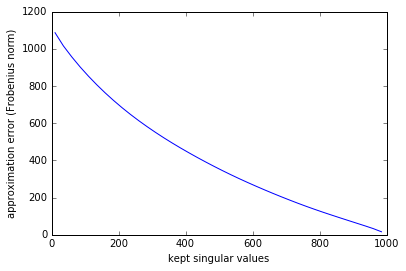

In [17]:
plt.plot(ks, errors)
plt.xlabel("kept singular values")
plt.ylabel("approximation error (Frobenius norm)")

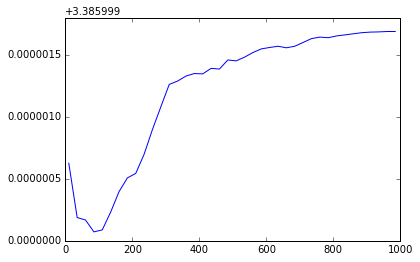

In [18]:
# Sanity
plt.plot(ks, means)

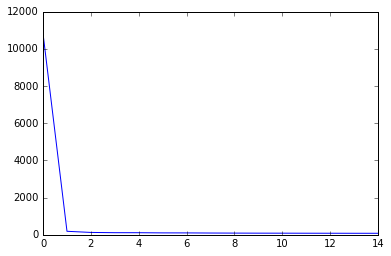

In [19]:
# Plot the singular value spectrum
plt.plot(np.arange(15), d[:15])

In [20]:
rmses = []
for k in range(5, 50, 1):
    U_lim = U[:,:k]
    D_lim = D[:k, :]
    V_lim = V[:,:]

    k_prediction = np.dot(U_lim, np.dot(D_lim, V_lim.T))
    k_prediction = k_prediction[:, :1000]
    rmses.append((k, score_predictions(k_prediction, validation_matrix)))

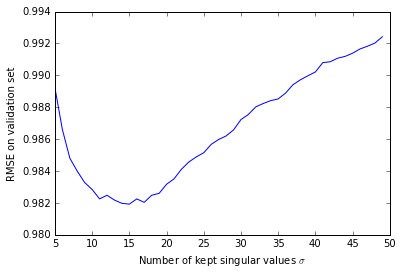

In [21]:
plt.plot([e[0] for e in rmses], [e[1] for e in rmses])
plt.xlabel("Number of kept singular values $\sigma$")
plt.ylabel("RMSE on validation set")

# Cross-validation (experimental)

In [22]:
from sklearn.cross_validation import KFold

In [23]:
CV_FOLDS = 5
folds = KFold(len(all_ratings), n_folds=CV_FOLDS, shuffle=True)

# TODO(andrei) Implement predictions as a subclass of BaseEstimator
# and/or RegressionEstimator so we can use it with e.g. grid searches.

k = 3

# A 2D array where every row is a data point. The first column specifies
# the row in the data matrix where the rating belongs, the second column,
# its column. The third one is the actual rating.
all_ratings_np = np.array(all_ratings)
all_ratings_np.shape

(1388107, 3)

In [47]:
# A few sanity checks;
# TODO(andrei) Delete once you're done.

item_i = predict_by_avg_item_rating(data_matrix)
user_i = predict_by_avg_user_rating(data_matrix)
avg_i = predict_by_avg_avg(data_matrix)

Got 1000 average ratings.
Got 10000 average ratings.
Got 1000 average ratings.
Got 10000 average ratings.
(10000, 1000)
(10000, 1000)
(10000, 1000)


In [48]:
print(item_i.shape)
print(avg_i.shape)

print(item_i[item_i <= 0])
print(avg_i[avg_i <= 0])

print(item_i[item_i > 5])
print(avg_i[avg_i > 5])

print(len(item_i[item_i == 3]))
print(len(avg_i[avg_i == 3]))

print(np.mean(item_i))
print(len(avg_i[np.isnan(item_i)]))
print(len(avg_i[np.isnan(user_i)]))
print(len(avg_i[np.isnan(avg_i)]))

(10000, 1000)
(10000, 1000)
[]
[]
[]
[]
411701
402486
3.385954753
0
1000
1000


In [26]:
# We will not use 'svd_predict' and instead we will use a dirty trick
# to significantly speed up our cross-validation scores.

# For every fold, results will contain a list of len(ks) scores.
# This is an unorthodox way of doing CV, but it's much faster since
# we only do one SVD per fold, instead of one per (k * folds).
results = []

ks = range(1, 30, 1)
imputation_fn = predict_by_avg_item_rating
# imputation_fn = predict_by_avg_avg
for train_index, test_index in folds:
    train = all_ratings_np[train_index]
    test = all_ratings_np[test_index]
     
    train_matrix = ratings_to_matrix(train, USER_COUNT, ITEM_COUNT)
    test_matrix = ratings_to_matrix(test, USER_COUNT, ITEM_COUNT)
    
    print("Performing imputation...")
    imputed = imputation_fn(train_matrix)
    print("Performing SVD...")
    U, d, V = np.linalg.svd(imputed, full_matrices=True)
    print("SVD done.")
    V = V.T

    D = np.zeros_like(imputed)
    D[:d.shape[0], :d.shape[0]] = np.diag(d)

    rmses = []
    for k in ks:
        U_k = U[:, :k]
        D_k = D[:k, :]
        V_k = V[:, :]
        
        k_prediction = np.dot(U_k, np.dot(D_k, V_k.T))
        k_prediction = k_prediction[:, :1000]
        rmses.append((k, score_predictions(k_prediction, test_matrix)))

    results.append(rmses)
    
print("Done.")

Building [10000 x 1000] rating matrix.
Finished building rating matrix.
Building [10000 x 1000] rating matrix.
Finished building rating matrix.
Performing imputation...
Got 1000 average ratings.
Performing SVD...
SVD done.
Building [10000 x 1000] rating matrix.
Finished building rating matrix.
Building [10000 x 1000] rating matrix.
Finished building rating matrix.
Performing imputation...
Got 1000 average ratings.
Performing SVD...
SVD done.
Building [10000 x 1000] rating matrix.
Finished building rating matrix.
Building [10000 x 1000] rating matrix.
Finished building rating matrix.
Performing imputation...
Got 1000 average ratings.
Performing SVD...
SVD done.
Building [10000 x 1000] rating matrix.
Finished building rating matrix.
Building [10000 x 1000] rating matrix.
Finished building rating matrix.
Performing imputation...
Got 1000 average ratings.
Performing SVD...
SVD done.
Building [10000 x 1000] rating matrix.
Finished building rating matrix.
Building [10000 x 1000] rating matri

In [27]:
cv_rmses = []
for index, k in enumerate(ks):
    score = 0
    for fold in range(CV_FOLDS):
        score += results[fold][index][1]
        
    avg_score = score / CV_FOLDS
    cv_rmses.append(avg_score)

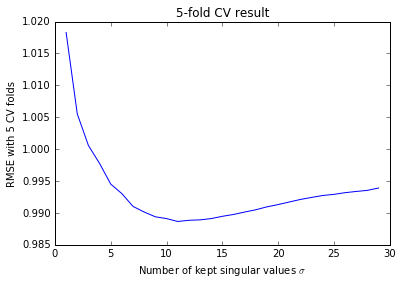

In [28]:
plt.plot(ks, cv_rmses)
plt.ylabel("RMSE with %d CV folds" % CV_FOLDS)
plt.xlabel("Number of kept singular values $\sigma$")
plt.title("%d-fold CV result" % CV_FOLDS)

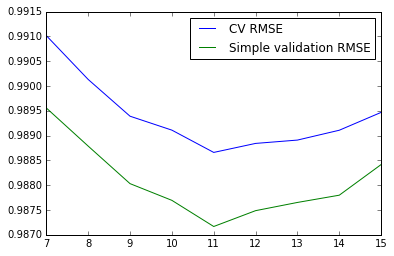

In [29]:
plt.plot(ks[6:15], cv_rmses[6:15], label="CV RMSE")
plt.plot([e[0] for e in rmses][6:15], [e[1] for e in rmses][6:15], label="Simple validation RMSE")
plt.legend()

# Kaggle test data output stuff

In [ ]:
test_result = svd_predict(data_matrix, k=11)

In [ ]:
import os
import time

def output_solution(solution_matrix):
    submisson_template = load_ratings('data/cf/sampleSubmission.csv')
    output = "Id,Prediction\n"
    for (row, col, _) in submisson_template:
        output += "r%d_c%d,%f\n" % (row + 1, col + 1, solution_matrix[row, col])
                
    return output

def output_solution_to_file(solution_matrix, technique, output_root='out/cf'):
    timestr = time.strftime("%Y%m%d-%H%M%S")
    file_name = "submission-%s-%s.csv" % (technique, timestr)
    file_path = os.path.join(output_root, file_name)
    with open(file_path, 'w') as output_file:
        output_text = output_solution(solution_matrix)
        output_file.write(output_text)

In [ ]:
output_solution_to_file(test_result, "vanilla")

In [ ]:
# This leads to a pretty crappy score over on Kaggle.

no_svd_kaggle_result = predict_by_avg_item_rating(data_matrix)

In [ ]:
output_solution_to_file(no_svd_kaggle_result, "only-item-rating-imputation")